## Lagrange Polynomials

This tutorial uses the same example as the [problem formulation](./problem_formulation.ipynb).

[Lagrange polynomials](https://en.wikipedia.org/wiki/Lagrange_polynomial) are not a method for creating orthogonal polynomials.
Instead it is an interpolation method for creating an polynomial expansion that has the property that each polynomial interpolates exactly one point in space with the value 1 and has the value 0 for all other interpolation values.

To summarize, we need to do the following:

* Generate $Q_1, ..., Q_N = (\alpha_1, \beta_1), ..., (\alpha_N, \beta_N)$, using (pseudo-)random samples or otherwise.
* Construct a Lagrange polynomial expansion $\Phi_1, ..., \Phi_M$ from the samples $Q_1, ..., Q_N$.
* Evaluate model predictor $U_1, ..., U_N$ for each sample.
* Analyze model approximation $u(t; \alpha, \beta) = \sum_m U_m(t) \Phi_n(\alpha, \beta)$ instead of actual model solver. 

### Evaluation samples

In chaospy, creating low-discrepancy sequences can be done using the `distribution.sample` method.
Creating quadrature points can be done using `chaospy.generate_quadrature`.
For example:

In [1]:
from problem_formulation import joint

samples = joint.sample(5, rule="halton")

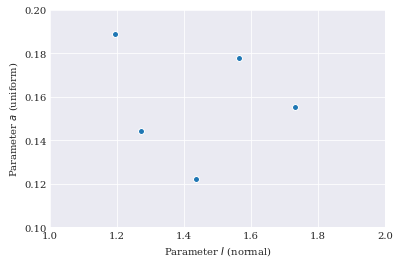

In [2]:
from matplotlib import pyplot

pyplot.scatter(*samples)
    
pyplot.rc("figure", figsize=[6, 4])
pyplot.xlabel("Parameter $I$ (normal)")
pyplot.ylabel("Parameter $a$ (uniform)")
pyplot.axis([1, 2, 0.1, 0.2])

pyplot.show()

### Lagrange basis

Creating an expansion of Lagrange polynomial terms can be done using the following constructor:

In [3]:
import chaospy

polynomial_expansion = chaospy.expansion.lagrange(samples)
polynomial_expansion[0].round(2)

polynomial(-694.24*q1**2+28.97*q0*q1+170.1*q1-6.65*q0-5.96)

On can verify that the returned polynomials follows the property of evaluating 0 for all but one of the samples used in the construction as follows:

In [4]:
polynomial_expansion(*samples).round(8)

array([[ 1., -0., -0., -0., -0.],
       [ 0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.],
       [-0., -0., -0.,  1.,  0.],
       [-0., -0., -0., -0.,  1.]])

### Model approximation

Fitting the polynomials to the evaluations does not need to involve regression.
Instead it is enough to just multiply the Lagrange polynomial expansion with the evaluations, and sum it up:

In [5]:
from problem_formulation import model_solver

model_evaluations = numpy.array([
    model_solver(sample) for sample in samples.T])
model_approximation = chaospy.sum(
    model_evaluations.T*polynomial_expansion, axis=-1).T

model_approximation.shape

(1000,)

### Assess statistics

The results is close to what we are used to from the other methods:

In [6]:
expected = chaospy.E(model_approximation, joint)
variance = chaospy.Var(model_approximation, joint)

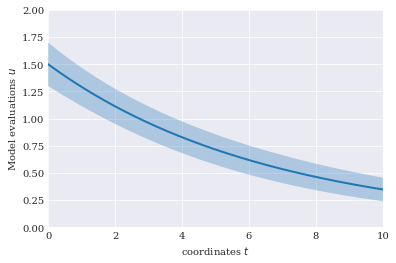

In [7]:
from problem_formulation import coordinates

pyplot.fill_between(coordinates, expected-variance**0.5,
                    expected+variance**0.5, alpha=0.3)
pyplot.plot(coordinates, expected)

pyplot.axis([0, 10, 0, 2])
pyplot.xlabel("coordinates $t$")
pyplot.ylabel("Model evaluations $u$")

pyplot.show()

### Avoiding matrix inversion issues

It is worth noting that the construction of Lagrange polynomials are not always numerically stable.
For example when using grids along , most often the expansion construction fails:

In [8]:
nodes, _ = chaospy.generate_quadrature(1, joint)

try:
    chaospy.expansion.lagrange(nodes)
except numpy.linalg.LinAlgError as err:
    error = err.args[0]
error

'Lagrange abscissas resulted in invertible matrix'

It is impossible to avoid the issue entirely, but in the case of structured grid, it is often possible to get around the problem.
To do so, the following steps can be taken:

* Create multiple Lagrange polynomials, one for each marginal distribution.
* Rotate dimensions so each expansion get a dimension corresponding to the marginal it was created for.
* Use an outer product of the expansions to combine them into a single expansion.

So we begin with making marginal Lagrange polynomials:

In [9]:
nodes, _ = list(zip(*[chaospy.generate_quadrature(1, marginal)
                      for marginal in joint]))
expansions = [chaospy.expansion.lagrange(nodes_)
              for nodes_ in nodes]

[expansion_.round(4) for expansion_ in expansions]

[polynomial([-0.3041*q0+0.9562, 0.3041*q0+0.0438]),
 polynomial([-10.0*q0+2.0, 10.0*q0-1.0])]

Then we rotate the dimensions:

In [10]:
vars_ = chaospy.variable(len(joint))
expansions = [
    expans(q0=var)
    for expans, var in zip(expansions, vars_)]

[expans.round(4) for expans in expansions]

[polynomial([-0.3041*q0+0.9562, 0.3041*q0+0.0438]),
 polynomial([-10.0*q1+2.0, 10.0*q1-1.0])]

And finally construct the final expansion using an outer product:

In [11]:
expansion = chaospy.outer(*expansions).flatten()
expansion.round(2)

polynomial([3.04*q0*q1-9.56*q1-0.61*q0+1.91,
            -3.04*q0*q1+9.56*q1+0.3*q0-0.96,
            -3.04*q0*q1-0.44*q1+0.61*q0+0.09,
            3.04*q0*q1+0.44*q1-0.3*q0-0.04])

The end results can be verified to have the properties we are looking for:

In [12]:
nodes, _ = chaospy.generate_quadrature(1, joint)
expansion(*nodes).round(8)

array([[ 1., -0., -0., -0.],
       [ 0.,  1.,  0.,  0.],
       [ 0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  1.]])